# IMDB exploratory data analysis to isolate factors which contribute most to movie profitability or popularity

In [ ]:
#need to make a table that has the top 33% of movies by popularity, with ratings over 7.0, and actors/actresses in the cast
#need to include the actor/actress name, movie name, rating, profit, and popularity
#adjust as needed
cte_mega_string = """

WITH FilteredRatings AS (
    SELECT tconst, averageRating, numVotes
    FROM dbo.ratings
    WHERE averageRating > 4.0
),
--break list by popularity into n-tile
FilteredPopularity AS (
    Select
        imdb_id,
        popularity,
        genres,
        overview,
        ProductionCompanies,
        NTILE(1) OVER (ORDER BY popularity DESC) AS popularity_percentile 
    from dbo.meta
),
FilteredBasics AS (
    SELECT tconst, primaryTitle, startYear, runtimeMinutes
    FROM dbo.basics
    WHERE startYear >= 2010
),
budget AS (
    SELECT 
        imdb_id,
        budget,
        (revenue - budget) AS profit
    FROM dbo.meta
)
SELECT DISTINCT TOP 100 --Left low for testing
    cast.tconst, -- movie number unique id
    base.primaryTitle, --movie name
    cast.category,
    rates.averageRating, -- ratings
    nam.primaryName AS actor_name,
    budget.budget,
    budget.profit,
    pop.popularity,
    pop.genres,
    pop.ProductionCompanies,
    pop.overview

FROM dbo.principals AS cast
JOIN FilteredBasics AS base ON base.tconst = cast.tconst
JOIN FilteredRatings AS rates ON rates.tconst = cast.tconst
JOIN budget on budget.imdb_id = cast.tconst
JOIN dbo.name AS nam ON nam.nconst = cast.nconst
JOIN FilteredPopularity AS pop ON pop.imdb_id = cast.tconst
WHERE cast.category IN ('actor', 'actress')
    AND pop.popularity_percentile = 1
ORDER BY pop.popularity DESC;
"""


In [4]:
import pandas as pd
from sqlalchemy import create_engine
# connection details
server = 'sourcetoshare.database.windows.net'
database = 'imdb'
username = 'jeffrey'
password = 'JAw1BcMunBB7JGgKoWDNRwnUvNxDvW5yUClzwlomuIY8='
driver = 'ODBC Driver 17 for SQL Server'


# Create the connection string in SQLAlchemy format
conn_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver.replace(" ", "+")}'

# Create the SQLAlchemy engine
engine = create_engine(conn_string)
# Execute the query and load the data into a pandas DataFrame
cte_df = pd.read_sql(cte_mega_string, conn_string)

# Display the first few rows of the dataframe
print(cte_df.head())

      tconst  primaryTitle category  averageRating         actor_name  \
0  tt0451279  Wonder Woman    actor            7.0         Chris Pine   
1  tt0451279  Wonder Woman    actor            7.0       Danny Huston   
2  tt0451279  Wonder Woman    actor            7.0      David Thewlis   
3  tt0451279  Wonder Woman    actor            7.0  Eugene Brave Rock   
4  tt0451279  Wonder Woman    actor            7.0       Ewen Bremner   

      budget     profit  popularity                      genres  \
0  149000000  671580447  294.337037  Action, Adventure, Fantasy   
1  149000000  671580447  294.337037  Action, Adventure, Fantasy   
2  149000000  671580447  294.337037  Action, Adventure, Fantasy   
3  149000000  671580447  294.337037  Action, Adventure, Fantasy   
4  149000000  671580447  294.337037  Action, Adventure, Fantasy   

                                 ProductionCompanies  \
0  Dune Entertainment, Atlas Entertainment, Warne...   
1  Dune Entertainment, Atlas Entertainment, Wa

In [5]:
# first we need to clean up the data
# 1. remove empties
cte_df = cte_df.dropna()
# 2. remove entries with budgets of zero
cte_df = cte_df[cte_df['budget'] != 0]
#Creates a new binary column for each unique actor name. 
dummies_df = pd.get_dummies(cte_df, columns=['actor_name'])
dummies_df.head(n=5)


,tconst,primaryTitle,category,averageRating,budget,profit,popularity,genres,ProductionCompanies,overview,...,actor_name_Stanley Tucci,actor_name_Steve Toussaint,actor_name_Tim Allen,actor_name_Toby Jones,actor_name_Toby Kebbell,actor_name_Tom Hanks,actor_name_Tommy Lee Jones,actor_name_Ty Simpkins,actor_name_Vincent D'Onofrio,actor_name_Wallace Shawn
0,tt0451279,Wonder Woman,actor,7.0,149000000,671580447,294.337037,"Action, Adventure, Fantasy","Dune Entertainment, Atlas Entertainment, Warne...",An Amazon princess comes to the world of Man t...,...,False,False,False,False,False,False,False,False,False,False
1,tt0451279,Wonder Woman,actor,7.0,149000000,671580447,294.337037,"Action, Adventure, Fantasy","Dune Entertainment, Atlas Entertainment, Warne...",An Amazon princess comes to the world of Man t...,...,False,False,False,False,False,False,False,False,False,False
2,tt0451279,Wonder Woman,actor,7.0,149000000,671580447,294.337037,"Action, Adventure, Fantasy","Dune Entertainment, Atlas Entertainment, Warne...",An Amazon princess comes to the world of Man t...,...,False,False,False,False,False,False,False,False,False,False
3,tt0451279,Wonder Woman,actor,7.0,149000000,671580447,294.337037,"Action, Adventure, Fantasy","Dune Entertainment, Atlas Entertainment, Warne...",An Amazon princess comes to the world of Man t...,...,False,False,False,False,False,False,False,False,False,False
4,tt0451279,Wonder Woman,actor,7.0,149000000,671580447,294.337037,"Action, Adventure, Fantasy","Dune Entertainment, Atlas Entertainment, Warne...",An Amazon princess comes to the world of Man t...,...,False,False,False,False,False,False,False,False,False,False


# We'll start easy by just using the profit and popularity columns


In [6]:
correlation = dummies_df[['profit', 'popularity']].corr()
print(correlation)

              profit  popularity
profit      1.000000    0.223581
popularity  0.223581    1.000000


# Now we'll use all the actor columns and the popularity column, since we're interested in the relationship between the actors and the popularity of the movie
# We'll select all columns that start with 'actor_'
# since there are a ton of names we'll use a loop to create a bunch of columns

In [7]:

selected_columns = ['popularity'] + [col for col in dummies_df.columns if col.startswith('actor_')]
print(selected_columns[0:10])

['popularity', 'actor_name_Alex Veadov', 'actor_name_Alfred Molina', 'actor_name_Anthony Mackie', 'actor_name_BD Wong', 'actor_name_Ben Kingsley', 'actor_name_Bill Pullman', 'actor_name_Bruce Willis', 'actor_name_Bryce Dallas Howard', 'actor_name_Chloë Grace Moretz']


In [8]:
# Now we'll use all the actor columns and the popularity column, since we're interested in the relationship between the actors and the popularity of the movie
# We'll select all columns that start with 'actor_'
#since there are a ton of names we'll use a loop to create a bunch of columns

In [9]:
# Create a new dataframe with only the selected columns
new_df = dummies_df[selected_columns]

# Calculate the correlation matrix
pop_matrix = new_df.corr()

# remove the 100 correlation with itself
pop_matrix = pop_matrix.drop('popularity')

# Remove the 'actor_' prefix from the index
pop_matrix.index = pop_matrix.index.str.replace('actor_name_', '')

# Display the correlation matrix
pop_matrix= pop_matrix['popularity'].sort_values(ascending=False)

print(pop_matrix)

Eugene Brave Rock    0.297265
Ewen Bremner         0.297265
David Thewlis        0.297265
Robin Wright         0.297265
Danny Huston         0.297265
                       ...   
Michael Keaton      -0.047128
Estelle Harris      -0.047128
Don Rickles         -0.047128
Wallace Shawn       -0.047128
John Morris         -0.047128
Name: popularity, Length: 80, dtype: float64


# Correlation results for popularity and actors
# Those are not high correlations values. The presence of any actor does not seem to have a significant impact on the popularity of the movie.

In [10]:
# Now we'll use all the actor columns and the  column, since we're interested in the relationship between the actors and the profit of the movie
selected_columns = ['profit'] + [col for col in dummies_df.columns if col.startswith('actor_')]
new_df = dummies_df[selected_columns]
profit_matrix = new_df.corr()
profit_matrix = profit_matrix.drop('profit')
profit_matrix = profit_matrix['profit'].sort_values(ascending=False)
profit_matrix.index = profit_matrix.index.str.replace('actor_name_', '')
print(profit_matrix)

Irrfan Khan             0.231583
BD Wong                 0.231583
Chris Pratt             0.231583
Nick Robinson           0.231583
Ty Simpkins             0.231583
                          ...   
Ray Liotta             -0.121473
Joseph Gordon-Levitt   -0.121473
Powers Boothe          -0.121473
Mickey Rourke          -0.121473
Josh Brolin            -0.121473
Name: profit, Length: 80, dtype: float64


# Correlation result for profit and actors:
# Those are not high correlations values. The presence of any actor does not seem to have a significant impact on the profit of the movie.

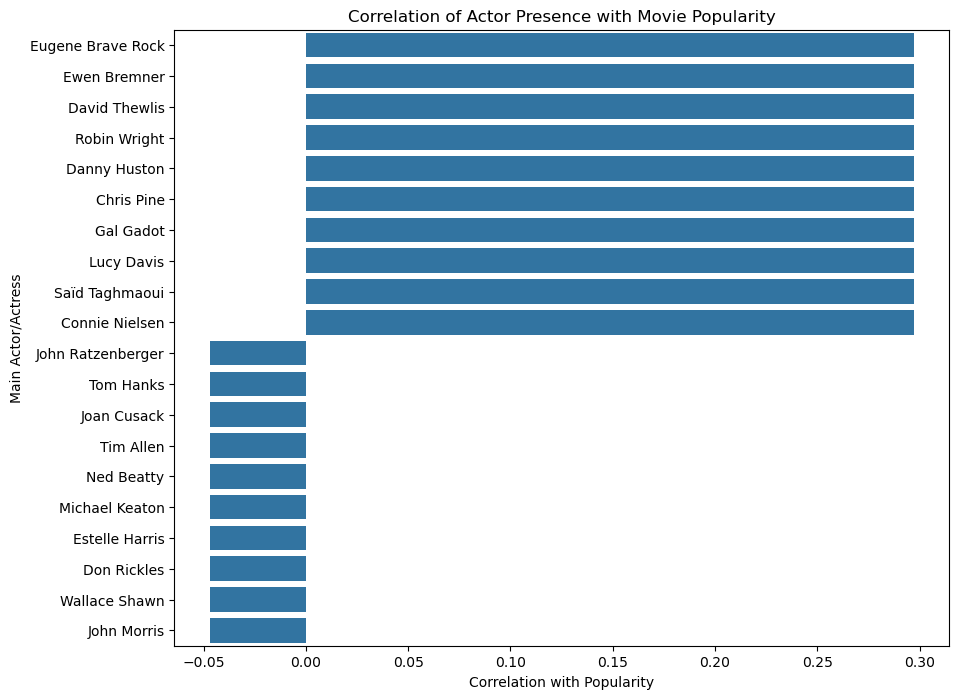

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate the correlation matrixa Keep only the top 10 and bottom 10 correlations
top_10 = pop_matrix.head(10)
bottom_10 = pop_matrix.tail(10)
top_bottom_20 = pd.concat([top_10, bottom_10])

# Display the modified correlation series
# Plot the correlations

plt.figure(figsize=(10, 8))
sns.barplot(x=top_bottom_20.values, y=top_bottom_20.index)
plt.xlabel('Correlation with Popularity')
plt.ylabel('Main Actor/Actress')
plt.title('Correlation of Actor Presence with Movie Popularity')
plt.show()

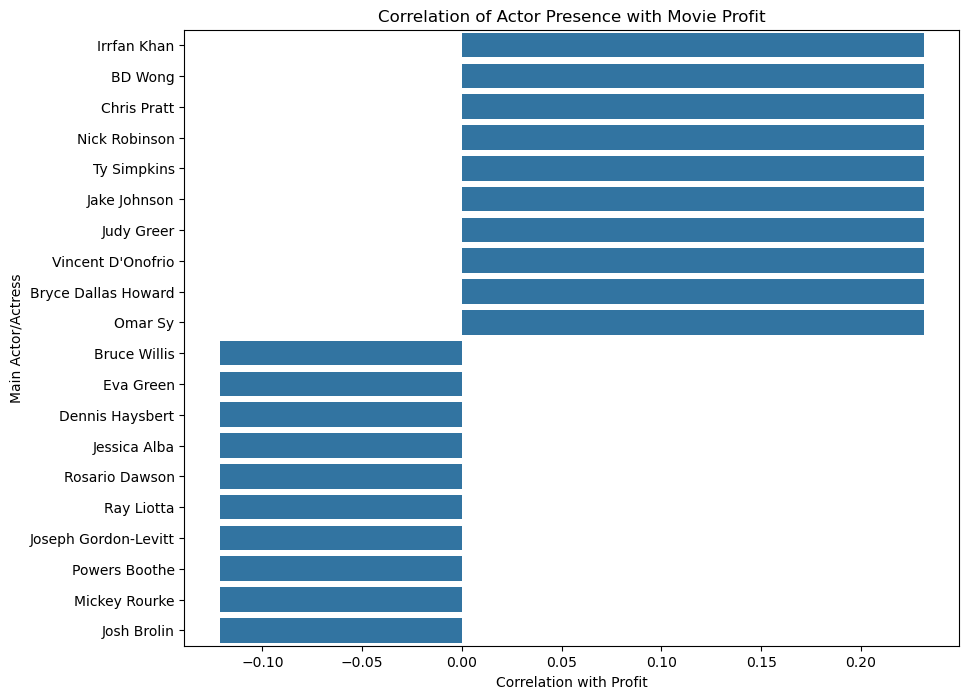

In [12]:

# Calculate the correlation  Keep only the top 10 and bottom 10 correlations
top_10 = profit_matrix.head(10)
bottom_10 = profit_matrix.tail(10)
top_bottom_20 = pd.concat([top_10, bottom_10])

# Display the modified correlation series
# Plot the correlations

plt.figure(figsize=(10, 8))
sns.barplot(x=top_bottom_20.values, y=top_bottom_20.index)
plt.xlabel('Correlation with Profit')
plt.ylabel('Main Actor/Actress')
plt.title('Correlation of Actor Presence with Movie Profit')
plt.show()

 # I found this odd. Anyone see something I am doing wrong? I will do a random forrest now to see which factor contributes the most to popularity and profit. That will also to rank them. I thought for sure this star-power would matter more than this, but perhaps when I compare it to the other variables which may influence popularity or profit, star-power may yet be at the top.
 # I realized after talking with Derrick that I can't form a correlation with a list of names even if I matrix them. So this isn't correlating what I think it is. It isn't doing anything meaningful. I feel dumb... moving on.


In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# We assign a target for the random forest model:
target_column = 'profit'

# Create a new data frame suitable for the arrandom forest model
# shallow copy: dataframe copy() method, to make sure we don't alter the original data
rand_forrest_df = cte_df.copy()

# try to drop columns which are not useful especially if they are strings
for col in rand_forrest_df.columns: #iterate through all columns
    if rand_forrest_df[col].dtype == 'object': # if the column is a string

        # then drop the column if it is not actor name genres or production companies
        if col not in ['actor_name', 'genres', 'ProductionCompanies']: 
            rand_forrest_df.drop(columns=[col], inplace=True)
print(' ---   This is what the column headers it looks like now:   \n')
print(rand_forrest_df.columns)
print('\n')
print(' ---   This is what it looks like now:\n')
print(rand_forrest_df.head())
print('\n')

 ---   This is what the column headers it looks like now:   

Index(['averageRating', 'actor_name', 'budget', 'profit', 'popularity',
       'genres', 'ProductionCompanies'],
      dtype='object')


 ---   This is what it looks like now:

   averageRating         actor_name     budget     profit  popularity  \
0            7.0         Chris Pine  149000000  671580447  294.337037   
1            7.0       Danny Huston  149000000  671580447  294.337037   
2            7.0      David Thewlis  149000000  671580447  294.337037   
3            7.0  Eugene Brave Rock  149000000  671580447  294.337037   
4            7.0       Ewen Bremner  149000000  671580447  294.337037   

                       genres  \
0  Action, Adventure, Fantasy   
1  Action, Adventure, Fantasy   
2  Action, Adventure, Fantasy   
3  Action, Adventure, Fantasy   
4  Action, Adventure, Fantasy   

                                 ProductionCompanies  
0  Dune Entertainment, Atlas Entertainment, Warne...  
1  Dune Enter

In [17]:

# Separate features and target (profit)

features = rand_forrest_df.drop(columns=[target_column])
features = features.drop(columns=['popularity'])
features = features.drop(columns=['budget']) #drop budget since this is presumably fixed
features = features.drop(columns=['averageRating']) #drop average rating since we can't control this 
target = rand_forrest_df[target_column]

# One-hot encode the categorical features (actor names, genres, production companies...)

for column in features.select_dtypes(include=['object']).columns:
    # Encode, append in place
    features = pd.concat([features, pd.get_dummies(features[column])], axis=1) 
    features.drop(column, axis=1, inplace=True) #drop the original column

print(' ---   This is the new size of our matrix (as in table):   \n')
print(features.size)
print('\n')
print(' ---   This is the columns:   \n')
print(' ---   \n see it is huge: ' + str(features.columns.size) + ' columns \n')
print(features.columns)
print('\n')
print(' ---   This is what the data looks like now:\n')
print(features.head())
print('\n')


 ---   This is the new size of our matrix (as in table):   

7680


 ---   This is the columns:   

 ---   
 see it is huge: 96 columns 

Index(['Alex Veadov', 'Alfred Molina', 'Anthony Mackie', 'BD Wong',
       'Ben Kingsley', 'Bill Pullman', 'Bruce Willis', 'Bryce Dallas Howard',
       'Chloë Grace Moretz', 'Chris Evans', 'Chris Pine', 'Chris Pratt',
       'Connie Nielsen', 'Dakota Goyo', 'Danny Huston', 'David Harbour',
       'David Meunier', 'David Thewlis', 'Dennis Haysbert',
       'Denzel Washington', 'Dominic Cooper', 'Don Rickles', 'Estelle Harris',
       'Eugene Brave Rock', 'Eva Green', 'Evangeline Lilly', 'Ewen Bremner',
       'Gal Gadot', 'Gemma Arterton', 'Gísli Örn Garðarsson', 'Haley Bennett',
       'Hayley Atwell', 'Hope Davis', 'Hugh Jackman', 'Hugo Weaving',
       'Irrfan Khan', 'Jake Gyllenhaal', 'Jake Johnson', 'James Rebhorn',
       'Jessica Alba', 'Joan Cusack', 'John Gatins', 'John Morris',
       'John Ratzenberger', 'Johnny Skourtis', 'Joseph Gordon-L

In [18]:

# Split into training and testing data
# Testing on 30% of the data
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Initialize the random forest model
# n_estimators is the number of trees in the forest
# random_state is the seed used by the random number generator
rand_for = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rand_for.fit(x_train, y_train)

# Predict the profit on the test seta
y_predict = rand_for.predict(x_test)

# Calculate the mean squared error
mse = np.mean((y_predict - y_test) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

# report the accuracy of the model
r2_score = rand_for.score(x_test, y_test)
print(f"R² (Model Accuracy): {r2_score}")


Mean Squared Error (MSE): 16063991099048.818
R² (Model Accuracy): 0.9999128848515687


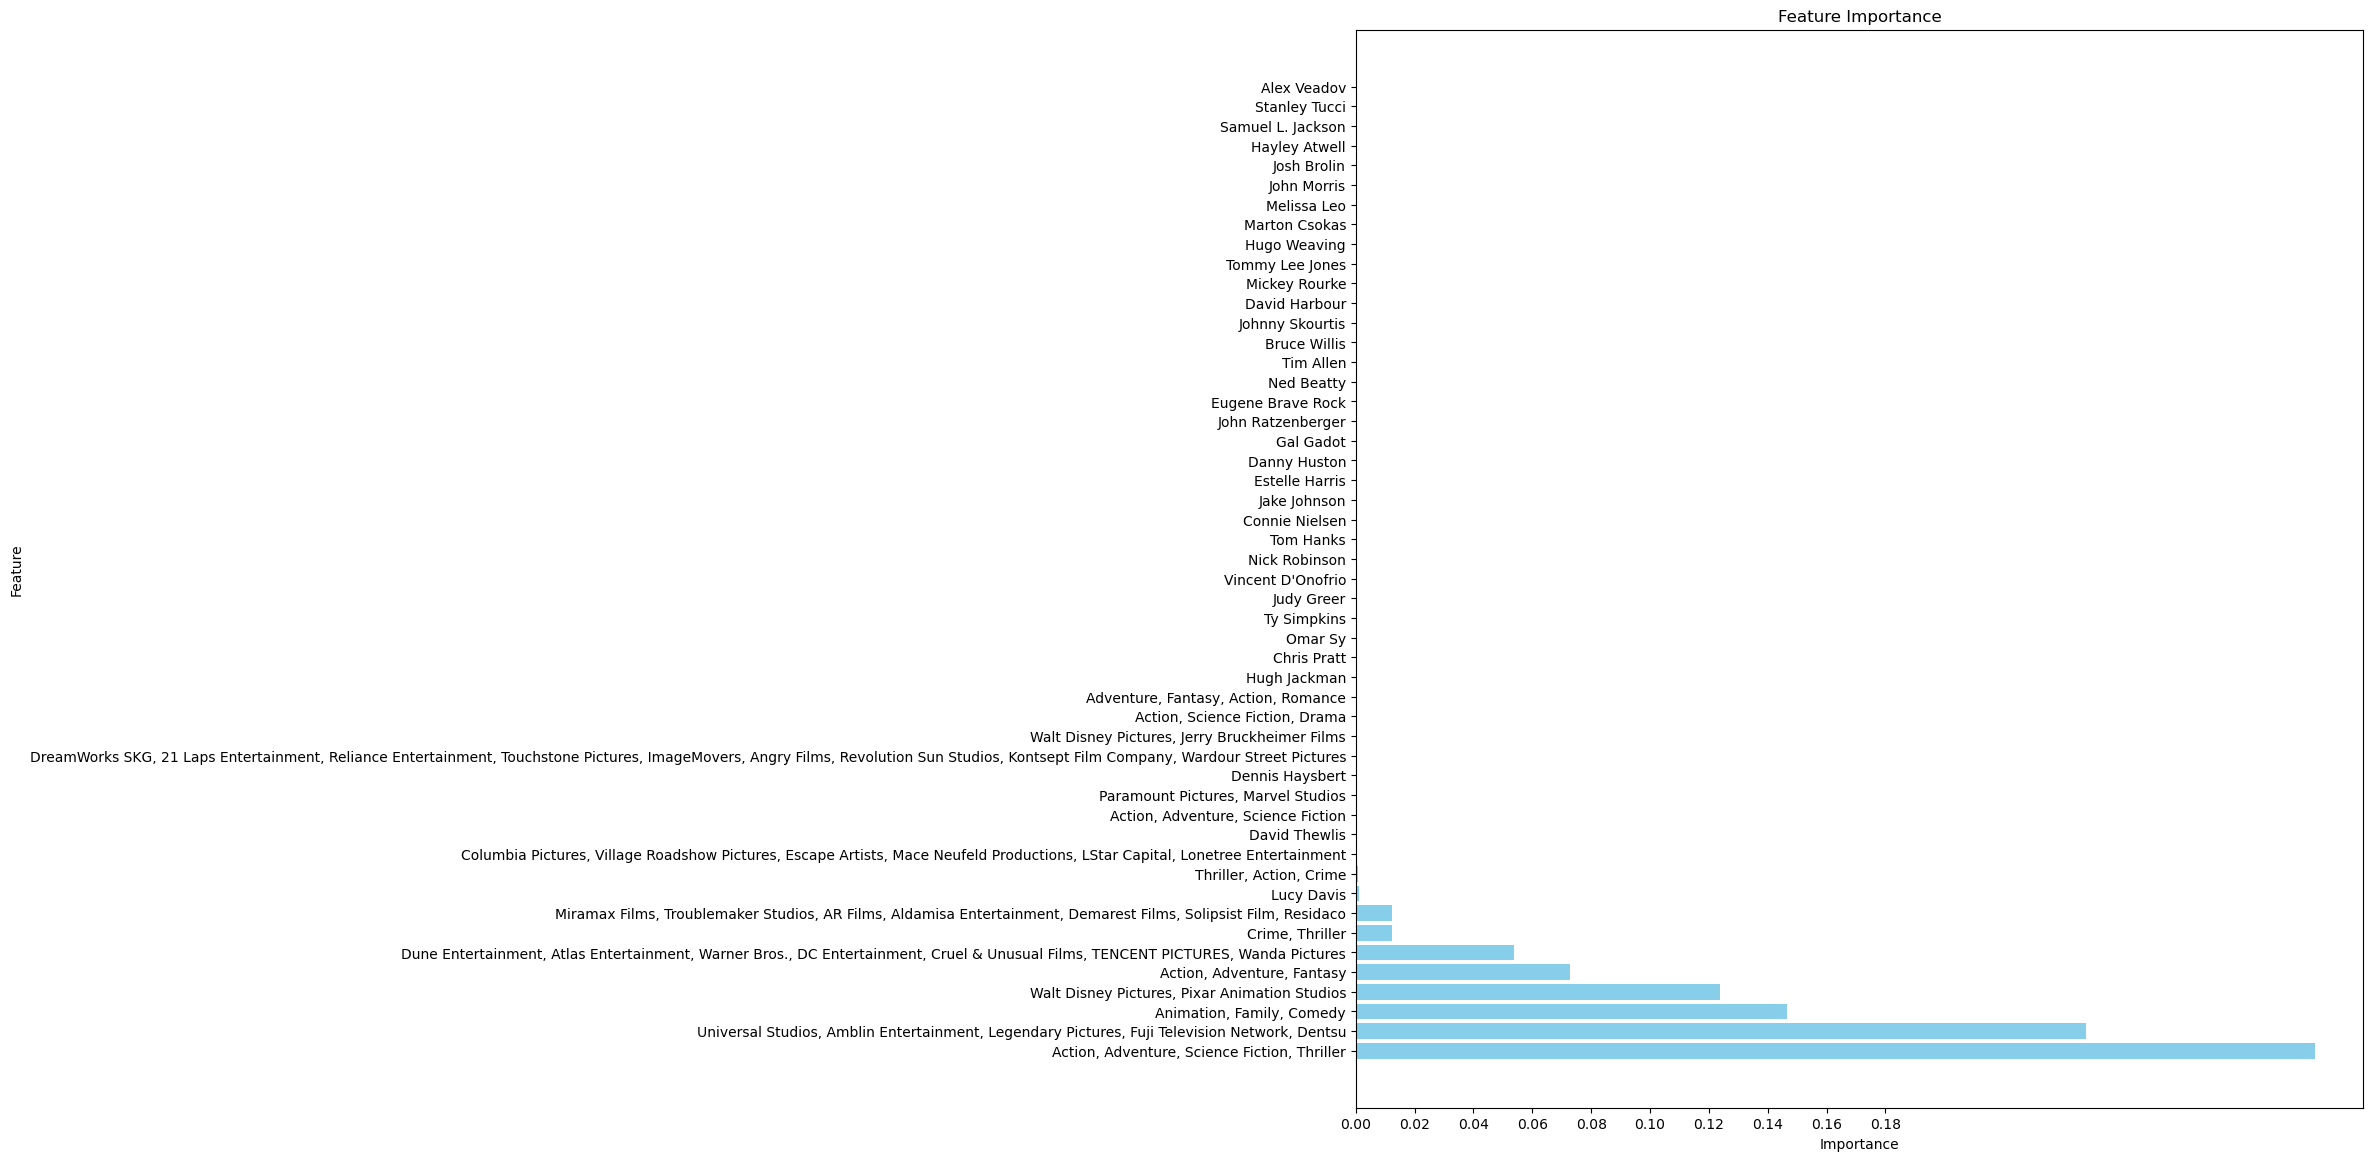

In [19]:
# Let's get a list of the most important features
# And get a visual representation of the importance of each feature
# There are way too many to display all of them, so we'll just display the top 10

import matplotlib.pyplot as plt
import numpy as np

# Get the feature importances, and the feature names
features_importance = rand_for.feature_importances_
feature_names = features.columns

# Create a dataframe with the feature importances
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': features_importance
})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

top_10_features = feature_df.head(50)

# plotting the feature importances
plt.figure(figsize=(13, 14))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
# Add labels
plt.title('Feature Importance')
plt.xticks(np.arange(0, 0.2, 0.02))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# The plot generated by the provided code is a horizontal bar plot that visualizes the importance of the top 10 features in your trained RandomForestRegressor model.  Feature importance is a measure of how much each feature contributes to the model's predictions. Higher importance values indicate that the feature has a greater impact on the model's output.


# Not suprisingly the budget and popularity and things that are clearly related to profit are most predictive. But since we cannot control those things we can draw a conclusion that the most predictive and controllable thing is the production company, namely a big budget one like Warner Bros, Hedya Films, whoever they are.



"""
 Let's try a different approach. 
 The problem is that we have tried to individualize the importance of the actors 
 This isn't going to work since there are so many different actors that any one actor's 
 importance is going to be very low. What we really need is a way to compute the importance that "ACTORS" catagories matter.
 New plan: We are going to try to predict the profit of a movie based on the actors in the movie as a whole.
 how? we are going to create a new column that is the sum of all the actors in the movie individually,
 then j
"""


Index(['averageRating', 'actor_name', 'budget', 'profit', 'popularity',
       'genres', 'ProductionCompanies'],
      dtype='object')
the features array contains 96 entries
Alex Veadov importance is 7.348989847388648e-19
Alfred Molina importance is 8.864746945981941e-19
Anthony Mackie importance is 8.864746945981941e-19
BD Wong importance is 8.864746945981941e-19
Ben Kingsley importance is 1.0826496304713874e-18
Bill Pullman importance is 1.0826496304713874e-18
Bruce Willis importance is 2.7055636013473977e-18
Bryce Dallas Howard importance is 2.7055636013473977e-18
Chloë Grace Moretz importance is 2.7055636013473977e-18
Chris Evans importance is 2.7055636013473977e-18
Chris Pine importance is 2.7055636013473977e-18
Chris Pratt importance is 2.712542851465038e-17
Connie Nielsen importance is 3.247842955159686e-17
Dakota Goyo importance is 3.2605914224320144e-17
Danny Huston importance is 3.6985103157711145e-17
David Harbour importance is 3.849153761004385e-17
David Meunier importance 

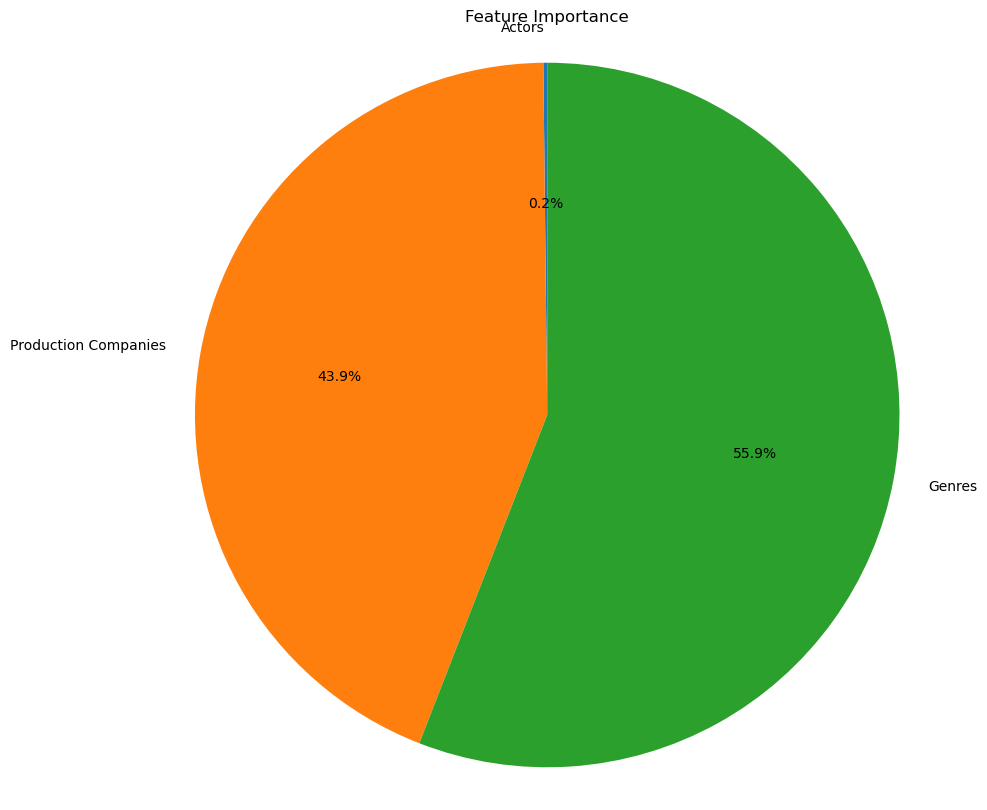

In [ ]:
# Let's examine the importances of actors
# let's get the feature importances, and the feature names

#print(rand_forrest_df.columns)
f_importance = rand_for.feature_importances_
f_names = features.columns
importance_df = pd.DataFrame({'Feature' : f_names, 'Importances' : f_importance})
total_importance = 0
actor_importance = 0
production_importance = 0
genre_importance = 0

print(rand_forrest_df.columns)

print(f'the features array contains {f_names.size} entries')
for name in f_names:
    if name in rand_forrest_df['actor_name'].values:
        actor_importance += importance_df[importance_df['Feature'] == name]['Importances'].values[0]
    if name in rand_forrest_df['ProductionCompanies'].values:
        production_importance += importance_df[importance_df['Feature'] == name]['Importances'].values[0]
    if name in rand_forrest_df['genres'].values:
        genre_importance += importance_df[importance_df['Feature'] == name]['Importances'].values[0]
    

print(f"Actor importance is {actor_importance}")
print(f"Production importance is {production_importance}")
print(f"Genre importance is {genre_importance}")
print(f"Total importance is {actor_importance + production_importance + genre_importance}")

# lets make a pie chart
plt.figure(figsize=(10, 10))
labels = ['Actors', 'Production Companies', 'Genres']
sizes = [actor_importance, production_importance, genre_importance]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Feature Importance') 
plt.show()

PART II

# Well, that was fun. But we still haven't compared the value of actors versus writers, directors, and the like. The SQL query will be different enough here to warrant a new SQL query.
#
# So let's get a new search, one that returns the other people who make movies possible and see what we get. We will also take the max amount of data from the data base.


In [70]:
import pandas as pd
CTE_all_emplyees = """
WITH FilteredRatings AS (
    SELECT 
        tconst, 
        averageRating,
        numVotes
    FROM dbo.ratings
    --WHERE averageRating > 8.0
),
FilteredPopularity AS (
    Select
        imdb_id,
        popularity,
        ProductionCompanies
    from dbo.meta
),
FilteredBasics AS (
    SELECT tconst,
    primaryTitle,
    startYear,
    runtimeMinutes
    FROM dbo.basics
    WHERE startYear > 2000
),
Budget AS (
    SELECT 
        imdb_id,
        (revenue - budget) / budget AS profit_ratio
    FROM dbo.meta
    Where budget >0
    AND productioncountries = 'United States of America'
)
SELECT DISTINCT TOP 10000
    cast.tconst, -- movie number unique id
    base.primaryTitle, --movie name
    cast.category,
    rates.averageRating, -- ratings
    nam.primaryName AS employee,
    base.runtimeMinutes,
    pop.ProductionCompanies,
    budget.profit_ratio

FROM dbo.principals AS cast
JOIN FilteredBasics AS base ON base.tconst = cast.tconst
JOIN FilteredRatings AS rates ON rates.tconst = cast.tconst
JOIN budget on budget.imdb_id = cast.tconst
JOIN dbo.name AS nam ON nam.nconst = cast.nconst
JOIN FilteredPopularity AS pop ON pop.imdb_id = cast.tconst
"""
import time
from datetime import datetime

current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
date = datetime.now().strftime("%m-%d")
forrest_df = pd.read_sql(CTE_all_emplyees, conn_string)
cte = "movies_catigories_" + date + current_time + ".csv"
printfile = forrest_df.to_csv(cte, index=False)
# Display the first few rows of the dataframe
print(forrest_df.head())
forrest_df = forrest_df.dropna()
#save to file
forrest_df.to_csv('Movies_emp_cat_BIG.csv', index=False)

      tconst           primaryTitle         category  averageRating  \
0  tt0145937             Naqoyqatsi  archive_footage            6.0   
1  tt0348150       Superman Returns  archive_footage            6.0   
2  tt0343121    Tupac: Resurrection  archive_footage            8.0   
3  tt0310793  Bowling for Columbine             self            8.0   
4  tt0405676     All the King's Men         composer            6.0   

          employee  runtimeMinutes  \
0    Marlon Brando              89   
1    Marlon Brando             154   
2     James Cagney             112   
3  Charlton Heston             120   
4     James Horner             128   

                                 ProductionCompanies  profit_ratio  
0  Miramax Films, Qatsi Productions, IRE Producti...             0  
1  DC Comics, Legendary Pictures, Warner Bros., B...             0  
2                      Paramount Pictures, MTV Films            25  
3  Alliance Atlantis Communications, TiMe Film- u...             7  

In [73]:
print(forrest_df.head())


      tconst           primaryTitle         category  averageRating  \
0  tt0145937             Naqoyqatsi  archive_footage            6.0   
1  tt0348150       Superman Returns  archive_footage            6.0   
2  tt0343121    Tupac: Resurrection  archive_footage            8.0   
3  tt0310793  Bowling for Columbine             self            8.0   
4  tt0405676     All the King's Men         composer            6.0   

          employee  runtimeMinutes  \
0    Marlon Brando              89   
1    Marlon Brando             154   
2     James Cagney             112   
3  Charlton Heston             120   
4     James Horner             128   

                                 ProductionCompanies  profit_ratio  
0  Miramax Films, Qatsi Productions, IRE Producti...             0  
1  DC Comics, Legendary Pictures, Warner Bros., B...             0  
2                      Paramount Pictures, MTV Films            25  
3  Alliance Atlantis Communications, TiMe Film- u...             7  

In [74]:
print(forrest_df.index.size)
print(f'Columns to look at: {forrest_df.columns}')
print(f'unique employees: {forrest_df["employee"].nunique()}')
all_comp_list = forrest_df['ProductionCompanies'].str.split(', ')
comp_count = all_comp_list.apply(len)
max_comps = comp_count.max()
print(f'max number of companies: {max_comps}')
all_comps = [company for sublist in all_comp_list for company in sublist]
unique_companies = set(all_comps)
print(f'unique production companies: {len(unique_companies)}')
print(f'unique categories: {forrest_df["category"].nunique()}')
print(f'All unique categories: {forrest_df["category"].unique()}')
#print(unique_companies)
max_comp_row = forrest_df.loc[comp_count.idxmax()].ProductionCompanies
print("Row with the maximum number of production companies:")
print(max_comp_row)

9570
Columns to look at: Index(['tconst', 'primaryTitle', 'category', 'averageRating', 'employee',
       'runtimeMinutes', 'ProductionCompanies', 'profit_ratio'],
      dtype='object')
unique employees: 5686
max number of companies: 9
unique production companies: 1040
unique categories: 12
All unique categories: ['archive_footage' 'self' 'composer' 'actor' 'actress' 'director'
 'producer' 'writer' 'cinematographer' 'editor' 'production_designer'
 'casting_director']
Row with the maximum number of production companies:
Imagine Entertainment, DreamWorks SKG, Universal Pictures, platinum studios, Reliance Entertainment, Relativity Media, K/O Paper Products, Fairview Entertainment, K/O Camera Toys


In [76]:
#lets split up the production companies, they are aggregated in the data

# Split the ProductionCompanies column into multiple columns
split_df = forrest_df['ProductionCompanies'].str.split(', ', expand=True)

# Ensure there are 9 columns, filling with None if there are fewer companies
for i in range(9):
    if i >= split_df.shape[1]:
        split_df[i] = None

# Rename the new columns
split_df.columns = [f'ProductionCompany{i+1}' for i in range(9)]

# Concatenate the new columns with the original DataFrame
df_expand = pd.concat([forrest_df, split_df], axis=1)

# Drop the original ProductionCompanies column if desired
df_expand = df_expand.drop(columns=['ProductionCompanies'])

print(df_expand.head())

      tconst           primaryTitle         category  averageRating  \
0  tt0145937             Naqoyqatsi  archive_footage            6.0   
1  tt0348150       Superman Returns  archive_footage            6.0   
2  tt0343121    Tupac: Resurrection  archive_footage            8.0   
3  tt0310793  Bowling for Columbine             self            8.0   
4  tt0405676     All the King's Men         composer            6.0   

          employee  runtimeMinutes  profit_ratio  \
0    Marlon Brando              89             0   
1    Marlon Brando             154             0   
2     James Cagney             112            25   
3  Charlton Heston             120             7   
4     James Horner             128             0   

                 ProductionCompany1                  ProductionCompany2  \
0                     Miramax Films                   Qatsi Productions   
1                         DC Comics                  Legendary Pictures   
2                Paramount Pictures

In [80]:
target = 'profit_ratio'
#forrest_df = forrest_df.drop(columns=['averageRating']) #drop average rating since we can't control this 
#forrest_df = forrest_df.drop(columns=['tconst']) #drop tconst, not generalizable
#forrest_df = forrest_df.drop(columns=['primaryTitle']) #drop title, not generalizable

# Separate features and target (profit)
features_df = forrest_df.drop(columns=[target]).drop(columns=['tconst']).drop(columns=['averageRating']).drop(columns=['primaryTitle'])
file_out = features_df.to_csv('features_df.csv', index=False)
target_df = forrest_df[target]
features_df.to_csv('features_df.csv', index=False)
print(features_df.select_dtypes(include=['object']).columns)
# One-hot encode the categorical features (actor names, genres, production companies...)
for column in features_df.select_dtypes(include=['object']).columns:
    print("here are the things to one-hot encode:", column)
    features_df = pd.concat([features_df, pd.get_dummies(features_df[column], dummy_na=False)], axis=1) 
    features_df.drop(column, axis=1, inplace=True) #drop the original column

# make sure the target and features have the same rows
assert features_df.index.size == target_df.index.size, "mismatched rows"


Index(['category', 'employee', 'ProductionCompanies'], dtype='object')
here are the things to one-hot encode: category
here are the things to one-hot encode: employee
here are the things to one-hot encode: ProductionCompanies


# this is a massive data set time to bring out the big guns
# We need GPU power now
# I summon nvidia cuda coreeeees!

In [82]:
print(f'Size of features_df: {features_df.shape}')
print(features_df.columns)
printfile = features_df.head().to_csv('features_df_encoded.csv', index=False)
print(features_df.head())
duplicate_columns = features_df.columns[features_df.columns.duplicated()]

if len(duplicate_columns) > 0:
    print(f'Duplicate columns found: {uplicate_columns}!!!')
else:
    print('No duplicate columns found.')


Size of features_df: (9570, 6404)
Index(['runtimeMinutes', 'actor', 'actress', 'archive_footage',
       'casting_director', 'cinematographer', 'composer', 'director', 'editor',
       'producer',
       ...
       'Wendy Finerman Productions, Alcon Entertainment, Grosvenor Park Productions',
       'Wessler Entertainment', 'Whitewater Films', 'Winkler Films',
       'World Premiere Entertainment, Tule River Films', 'Yari Film Group',
       'Yari Film Group, Stratus Film Co.', 'Zero Sum Productions',
       'Zyzzyx LLC', 'i5 Films'],
      dtype='object', length=6404)
   runtimeMinutes  actor  actress  archive_footage  casting_director  \
0              89  False    False             True             False   
1             154  False    False             True             False   
2             112  False    False             True             False   
3             120  False    False            False             False   
4             128  False    False            False             F

In [87]:

import cudf
from cuml.model_selection import train_test_split 
from cuml.ensemble import RandomForestRegressor 
from cuml.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import time


# Convert the dataframes to cudf dataframes
features_cu = cudf.DataFrame(features_df)
target_cu = cudf.DataFrame(target_df)

# Testing on 30% of the data. Split into training and testing data# Separate features and target (profit)
x_train, x_test, y_train, y_test = train_test_split(features_cu, target_cu, test_size=0.3, random_state=42)

# Initialize model, n_estimators = number trees, random_state is the seed
model = RandomForestRegressor(n_estimators=300, random_state=42)

# Train the model
start_time = time.time()
model.fit(x_train, y_train)
end_time = time.time()

# Predict the profit on the test seta
prediction = model.predict(x_test)
print(f"Time taken: {end_time - start_time} seconds")


/home/skystarved/anaconda3/envs/rapids-24.10/lib/python3.12/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


Time taken: 5.5870466232299805 seconds


In [ ]:

import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Calculate the mean squared error
y_test_np = y_test.to_numpy()
prediction_np = prediction.to_numpy()
mse = mean_squared_error(y_test_np, prediction_np)
print(f"Mean Squared Error (MSE): {mse}")

# Report the accuracy of the model
r2 = r2_score(y_test_np, prediction_np)
print(f"R² (Model Accuracy): {r2}")




Mean Squared Error (MSE): 315.4586592094449
R² (Model Accuracy): 0.23617488145828247
R² (Model Accuracy): 0.23617500066757202


In [ ]:
import shap
explainer = shap.Explainer(model) 
shap_values = explainer.shap_values(X_train)


shap_importance = np.abs(shap_values).mean(axis=0) 
importance_df = pd.DataFrame({ 'feature': features_df.columns, 'importance': shap_importance }).sort_values(by='importance', ascending=False) 
print(importance_df)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: RandomForestRegressor()